<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/062623_SIR_rho_lambda_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [4]:
def generate_configuration_model(degree_sequence):
    # Create an empty graph and sum up the degrees
    G = nx.Graph()
    degree_sum = sum(degree_sequence)

    # Print error message if the sum is odd
    if degree_sum % 2 != 0:
        raise ValueError("Degree sum is odd")

    # Create a list of nodes based on the degree sequence
    nodes = []
    for node, degree in enumerate(degree_sequence):
        nodes.extend([node] * degree)

    # Shuffle the nodes list
    random.shuffle(nodes)

    # Track visited edges
    existing_edges = set()

    # Pair the nodes and add edges to the graph
    for i in range(0, len(nodes), 2):
        node1 = nodes[i]
        node2 = nodes[i + 1]

        # Check for self-edges and duplicate edges
        if node1 != node2 and (node1, node2) not in existing_edges:
            G.add_edge(node1, node2)
            existing_edges.add((node1, node2))
            existing_edges.add((node2, node1))

    return G

In [13]:
def SIR(nw, lb, n_samp):
    # initialize variables
    t_max = 10000
    #n_times = 100000  # number of time points at which rho_R is recorded and averaged
    #rho_R_av = np.zeros(n_times+1)  # Initialize rho_R_av as a numpy array of zeros
    #t_sav = np.zeros(n_times+1)  # Initialize t_sav as a numpy array of zeros
    #t_sav0 = 0
    mu = 1
    N = len(nw.nodes)
    degrees = dict(nw.degree())
    kmax = max(degrees.values())

    t_end = 0
    recovered_fractions = []  # Initialize list to store stifler fractions

    # Initialize states with susceptible individuals
    states = {j: 0 for j in nw.nodes()}

    for i_samp in range(1, n_samp+1):
        t = 0
        #n_sav = 0 # an index variable that keeps track of the current position in the rho_R_av array.
        #t_sav[n_sav] = t_sav0
        rho_R = 0

        # Randomly select an initial infected node
        inf = []
        initial_node = np.random.choice(nw.nodes())
        states[initial_node] = 1  # Set initial node as infected
        inf.append(initial_node)
        N_inf = 1
        N_e = nw.degree(initial_node)

        while N_inf != 0:
            total_rate = mu * N_inf + lb * N_e
            tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
            t += tau

            if t >= t_max:
                break

            # Update average rho_R at specific time points
            #while n_sav < n_times and t > t_sav[n_sav]:
            #    rho_R_av[n_sav] += rho_R
            #    n_sav += 1
            #    t_sav[n_sav] += t_max/n_times

            # Determine which event occurs
            event = np.random.uniform()
            p = (mu * N_inf) / total_rate

            # Determine if accept selected node based on degree distribution
            q_deg = np.random.uniform()

            if event <= p: # Recovery
              # Select an infected individual to recover
              recovered_node = np.random.choice(inf)
              if q_deg < degrees[recovered_node]/kmax:
                # Update states
                states[recovered_node] = 2  # Set node as recovered
                inf.remove(recovered_node)
                N_inf -= 1
                N_e -= nw.degree(recovered_node)
                # Update average rho_R
                rho_R += (1 / N)

            else: # Infection
              # Select an infected individual
              infected_node = np.random.choice(inf)
              if q_deg < degrees[infected_node]/kmax:
                # Select a susceptible neighbor to infect
                neighbors = list(nw.neighbors(infected_node))
                susceptible_neighbors = [n for n in neighbors if states[n] == 0]

                if len(susceptible_neighbors) > 0:
                    infected_neighbor = np.random.choice(susceptible_neighbors)

                    # Update states
                    states[infected_neighbor] = 1  # Set neighbor as infected
                    inf.append(infected_neighbor)
                    N_inf += 1
                    N_e += nw.degree(infected_neighbor)

        if N_inf == 0:
          t_end += t
          recovered_fractions.append(rho_R)
          #print(lb, t_end, rho_R)

        # Reset infected and recovered individuals
        for node, state in states.items():
            if state == 1 or state == 2:
                states[node] = 0  # Susceptible state is 0

    # Normalize the average rho_R values by dividing by the number of samples
    avg_recovered_frac = sum(recovered_fractions) / len(recovered_fractions)
    t_end_av = t_end/n_samp
    return avg_recovered_frac, t_end_av


[3, 3, 3, 3, 4, 5, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 6, 3, 3, 5, 3, 3, 3, 3, 3, 4, 4, 3, 3, 7, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 4, 3, 4, 5, 4, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 4, 3, 4, 3, 3, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 5, 3, 3, 3, 4, 5, 5, 3, 3, 4, 4, 5, 3, 3, 4, 3, 3, 3, 3, 3, 5, 6, 4, 3, 3, 3, 7, 6, 5, 3, 3, 3, 3, 3, 3, 4, 3, 3, 6, 7, 3, 3, 3, 5, 3, 4, 3, 4, 3, 5, 3, 3, 3, 3, 4, 7, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 10, 4, 3, 3, 4, 3, 3, 3, 3, 7, 3, 3, 3, 5, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 5, 3, 3, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 7, 4, 4, 4, 3, 3, 3, 3, 7, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

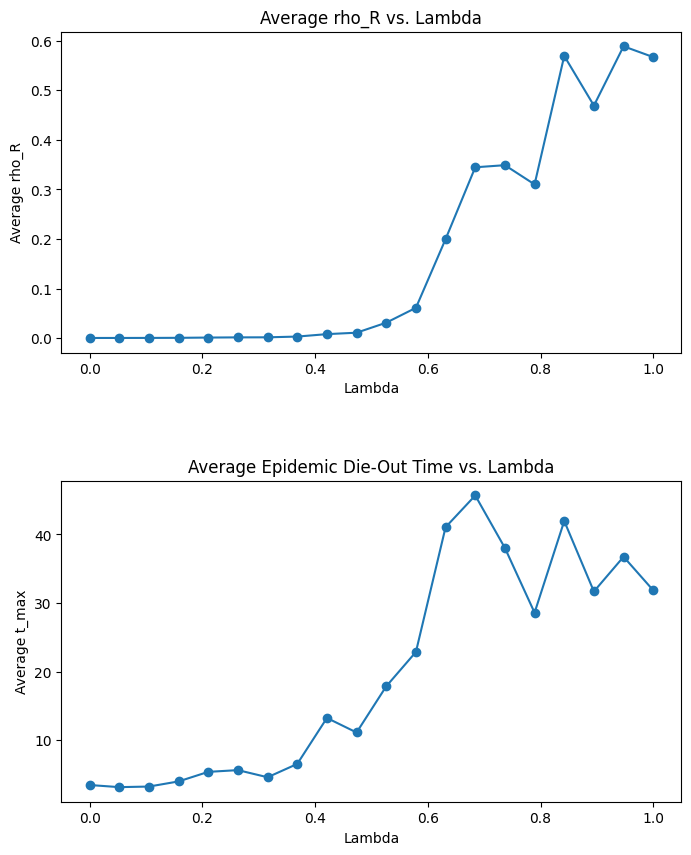

In [21]:
n= 2000
gamma = 4.0
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
print(degrees)
#nw = generate_configuration_model(degrees)
nw = nx.configuration_model(degrees)

n_samp = 50

lambda_values = np.linspace(0, 1, num=20)  # Generate lambda values from 0 to 1 with 0.05 steps
rho_R_av_values = []
t_end_av_values = []

for lb in lambda_values:
    rho_R_av, t_end_av = SIR(nw, lb, n_samp)
    rho_R_av_values.append(rho_R_av)  # Append the last value of rho_R_av to the list
    t_end_av_values.append(t_end_av)

# Convert the lists to numpy arrays
avg_rho_R_values = np.array(rho_R_av_values)
avg_t_end_values = np.array(t_end_av_values)

# Plot the two-panel graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Top panel: average rho_R against lambda
ax1.plot(lambda_values, avg_rho_R_values, 'o-')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Average rho_R')
ax1.set_title('Average rho_R vs. Lambda')

# Bottom panel: average epidemic die-out time t_max against lambda
ax2.plot(lambda_values, avg_t_end_values, 'o-')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Average t_max')
ax2.set_title('Average Epidemic Die-Out Time vs. Lambda')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the graph
plt.show()


[3, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 4, 3, 3, 8, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 5, 3, 3, 3, 3, 4, 3, 4, 3, 8, 4, 4, 3, 3, 3, 7, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 5, 3, 5, 4, 3, 3, 4, 3, 4, 5, 3, 3, 4, 5, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 5, 3, 7, 3, 3, 3, 4, 3, 3, 3, 4, 3, 5, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 5, 3, 3, 4, 3, 4, 3, 3, 4, 3, 5, 3, 3, 4, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5, 6, 12, 5, 3, 3, 4, 3, 4, 3, 4, 3, 4, 6, 3, 4, 3, 3, 4, 9, 3, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 4, 3, 4, 4, 3, 3, 5, 3, 3, 3, 3, 5, 3, 5, 9, 3, 3, 4, 3, 4, 3, 5, 4, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 4, 4, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 6, 4, 4, 7, 3, 3, 3, 6, 3, 5, 8, 3, 4, 3, 3, 3, 6, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,

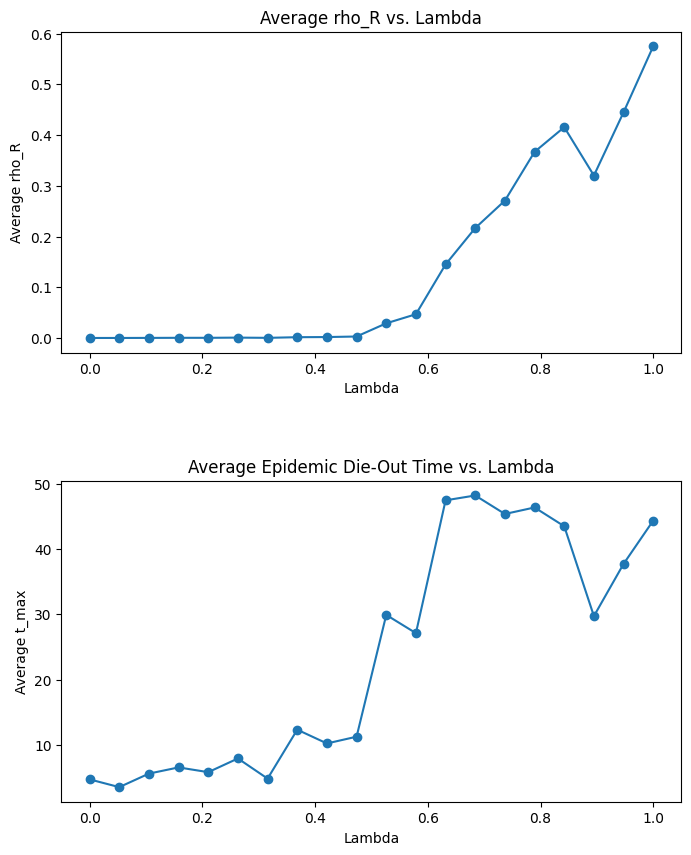

In [20]:
n= 5000
gamma = 4.0
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
print(degrees)
nw = generate_configuration_model(degrees)

n_samp = 30

lambda_values = np.linspace(0, 1, num=20)  # Generate lambda values from 0 to 1 with 0.05 steps
rho_R_av_values = []
t_end_av_values = []

for lb in lambda_values:
    rho_R_av, t_end_av = SIR(nw, lb, n_samp)
    rho_R_av_values.append(rho_R_av)  # Append the last value of rho_R_av to the list
    t_end_av_values.append(t_end_av)

# Convert the lists to numpy arrays
avg_rho_R_values = np.array(rho_R_av_values)
avg_t_end_values = np.array(t_end_av_values)

# Plot the two-panel graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Top panel: average rho_R against lambda
ax1.plot(lambda_values, avg_rho_R_values, 'o-')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Average rho_R')
ax1.set_title('Average rho_R vs. Lambda')

# Bottom panel: average epidemic die-out time t_max against lambda
ax2.plot(lambda_values, avg_t_end_values, 'o-')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Average t_max')
ax2.set_title('Average Epidemic Die-Out Time vs. Lambda')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the graph
plt.show()